In [1]:
import numpy as np

![jupyter](./picture_01.png)

参考：https://mp.weixin.qq.com/s/sg9O761F0KHAmCPOfMW_kQ

传播规则示例 : f(Hⁱ, A) = σ(AHⁱWⁱ)
其中，Wⁱ 是第 i 层的权重矩阵，σ 是非线性激活函数（如 ReLU 函数）。权重矩阵的维度为 Fⁱ × Fⁱ⁺¹，即权重矩阵第二个维度的大小决定了下一层的特征数。如果你对卷积神经网络很熟悉，那么你会发现由于这些权重在图中的节点间共享，该操作与卷积核滤波操作类似。

### 简化

接下来我们在最简单的层次上研究传播规则。令：

* i = 1，（约束条件 f 是作用于输入特征矩阵的函数）
* σ 为恒等函数
* 选择权重（约束条件： AH⁰W⁰ =AXW⁰ = AX）

换言之，f(X, A) = AX。该传播规则可能过于简单，后面会补充缺失的部分。此外，AX 等价于多层感知机的输入层。

In [2]:
# 构建图
A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 1, 1], 
    [0, 1, 0, 0],
    [1, 0, 1, 0]],
    dtype=float
)
# 构建 X 矩阵，基于每个节点的索引为其生成两个整数特征，这简化了本文后面手动验证矩阵运算的过程。
X = np.matrix([
            [i, -i]
            for i in range(A.shape[0])
        ], dtype=float)
print("A\n", A)
print("X\n", X)
print("AX\n", A * X) #  每个节点的表征（每一行）现在是其相邻节点特征的和x


A
 [[0. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 1. 0. 0.]
 [1. 0. 1. 0.]]
X
 [[ 0.  0.]
 [ 1. -1.]
 [ 2. -2.]
 [ 3. -3.]]
AX
 [[ 1. -1.]
 [ 5. -5.]
 [ 1. -1.]
 [ 2. -2.]]


### 问题

你可能已经发现了其中的问题：

* 节点的聚合表征不包含它自己的特征！该表征是相邻节点的特征聚合，因此只有具有自环（self-loop）的节点才会在该聚合中包含自己的特征 [1]。
* 度大的节点在其特征表征中将具有较大的值，度小的节点将具有较小的值。这可能会导致梯度消失或梯度爆炸 [1, 2]，也会影响随机梯度下降算法（随机梯度下降算法通常被用于训练这类网络，且对每个输入特征的规模（或值的范围）都很敏感）。

接下来，本文将分别对这些问题展开讨论。

In [3]:
# 单位阵
I = np.matrix(np.eye(A.shape[0]))
# 给G(V，E)加上自环
A_hat = A + I
print("A_hat\n", A_hat)
print("A_hat * X\n", A_hat * X)

A_hat
 [[1. 1. 0. 0.]
 [0. 1. 1. 1.]
 [0. 1. 1. 0.]
 [1. 0. 1. 1.]]
A_hat * X
 [[ 1. -1.]
 [ 6. -6.]
 [ 3. -3.]
 [ 5. -5.]]


### 对特征表征进行归一化处理

通过将邻接矩阵 A 与度矩阵 D 的逆相乘，对其进行变换，从而通过节点的度对特征表征进行归一化。因此，我们简化后的传播规则如下：
f(X, A) = D⁻¹AX

In [4]:
# 求出度矩阵
D = np.array(np.sum(A, axis=0))[0]
D = np.matrix(np.diag(D))
nor_AX = D**-1 * A * X 
print("D\n", D)
print("D^-1 * A\n", D**-1 * A) # 可以观察到，邻接矩阵中每一行的权重（值）都除以该行对应节点的度。 感觉就像每一行都归一化
print("nor_AX\n", nor_AX)

D
 [[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 1.]]
D^-1 * A
 [[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.  0.5 0.  0. ]
 [1.  0.  1.  0. ]]
nor_AX
 [[ 1.  -1. ]
 [ 2.5 -2.5]
 [ 0.5 -0.5]
 [ 2.  -2. ]]


### <center> 整合 </center>
    现在，我们将把自环和归一化技巧结合起来。此外，我们还将重新介绍之前为了简化讨论而省略的有关权重和激活函数的操作。

### 添加权重
    首先要做的是应用权重。请注意，这里的 D_hat 是 A_hat = A + I 对应的度矩阵，即具有强制自环的矩阵 A 的度矩阵。

In [5]:
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
print("D_hat\n", D_hat)

D_hat
 [[2. 0. 0. 0.]
 [0. 3. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 2.]]


In [6]:
W = np.matrix([
             [1, -1],
             [-1, 1]
         ])
D_hat**-1 * A_hat * X * W

matrix([[ 1., -1.],
        [ 4., -4.],
        [ 2., -2.],
        [ 5., -5.]])

In [7]:
# 如果我们想要减小输出特征表征的维度，我们可以减小权重矩阵 W 的规模：
W = np.matrix([
             [1],
             [-1]
         ])
D_hat**-1 * A_hat * X * W

matrix([[1.],
        [4.],
        [2.],
        [5.]])

### 添加激活函数

本文选择保持特征表征的维度，并应用 ReLU 激活函数。

In [8]:
def relu(x):
    return np.maximum(x, 0)
W = np.matrix([
             [1, -1],
             [-1, 1]
         ])
t = relu(D_hat**-1 * A_hat * X * W)
t

matrix([[1., 0.],
        [4., 0.],
        [2., 0.],
        [5., 0.]])

- 这就是一个带有邻接矩阵、输入特征、权重和激活函数的完整隐藏层 

## <center>在真实场景下的应用</center>

最后，我们将图卷积网络应用到一个真实的图上。本文将向读者展示如何生成上文提到的特征表征。

Zachary 空手道俱乐部

Zachary 空手道俱乐部是一个被广泛使用的社交网络，其中的节点代表空手道俱乐部的成员，边代表成员之间的相互关系。当年，Zachary 在研究空手道俱乐部的时候，管理员和教员发生了冲突，导致俱乐部一分为二。下图显示了该网络的图表征，其中的节点标注是根据节点属于俱乐部的哪个部分而得到的，「A」和「I」分别表示属于管理员和教员阵营的节点。

![jupyter](./picture_02.png)

![jupyter](./picture_03.png)

### 构建 GCN
    
接下来，我们将构建一个图卷积网络。我们并不会真正训练该网络，但是会对其进行简单的随机初始化，从而生成我们在本文开头看到的特征表征。我们将使用 networkx，它有一个可以很容易实现的 Zachary 空手道俱乐部的图表征。然后，我们将计算 A_hat 和 D_hat 矩阵。

In [9]:
from networkx import to_numpy_matrix,karate_club_graph

In [10]:
zkc = karate_club_graph()

In [11]:
print(list(zkc.node))
for i in zkc.node :
    print(i  , " : " , list(zkc[i]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
0  :  [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]
1  :  [0, 17, 2, 3, 21, 19, 7, 13, 30]
2  :  [0, 1, 3, 32, 7, 8, 9, 27, 28, 13]
3  :  [0, 1, 2, 7, 12, 13]
4  :  [0, 10, 6]
5  :  [0, 16, 10, 6]
6  :  [0, 16, 4, 5]
7  :  [0, 1, 2, 3]
8  :  [0, 32, 2, 30, 33]
9  :  [33, 2]
10  :  [0, 4, 5]
11  :  [0]
12  :  [0, 3]
13  :  [0, 1, 2, 3, 33]
14  :  [32, 33]
15  :  [32, 33]
16  :  [5, 6]
17  :  [0, 1]
18  :  [32, 33]
19  :  [0, 1, 33]
20  :  [32, 33]
21  :  [0, 1]
22  :  [32, 33]
23  :  [32, 25, 27, 29, 33]
24  :  [25, 27, 31]
25  :  [24, 31, 23]
26  :  [33, 29]
27  :  [24, 33, 2, 23]
28  :  [33, 2, 31]
29  :  [32, 33, 26, 23]
30  :  [8, 1, 33, 32]
31  :  [0, 32, 33, 24, 25, 28]
32  :  [33, 2, 8, 14, 15, 18, 20, 22, 23, 29, 30, 31]
33  :  [32, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30, 31]


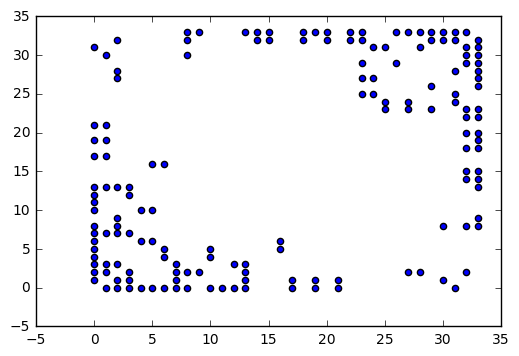

In [12]:
import matplotlib.pyplot as plt
x = []
y = []
for i in zkc.node :
    for j in range(len(list(zkc[i]))):
        x.append(i)
    for j in list(zkc[i]) :
        y.append(j)
plt.scatter(x, y)
plt.show()

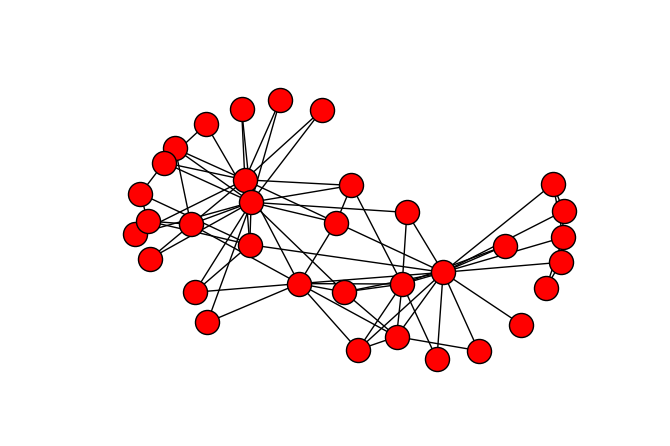

In [13]:
import networkx as nx 
G =nx.random_graphs.barabasi_albert_graph(100,1)   #生成一个BA无标度网络G
nx.draw(zkc)                          #绘制网络G
plt.savefig("ba.png")           #输出方式1: 将图像存为一个png格式的图片文件
plt.show()  

In [14]:
order = sorted(list(zkc.nodes()))
A = to_numpy_matrix(zkc, nodelist=order)
print(A, "\n\n" ,A.shape)

[[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]] 

 (34, 34)


In [15]:
I = np.eye(zkc.number_of_nodes())
I

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [16]:
A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
print(A_hat, "\n\n", D_hat)

[[1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]] 

 [[17.  0.  0. ...  0.  0.  0.]
 [ 0. 10.  0. ...  0.  0.  0.]
 [ 0.  0. 11. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  7.  0.  0.]
 [ 0.  0.  0. ...  0. 13.  0.]
 [ 0.  0.  0. ...  0.  0. 18.]]


In [21]:
print(D_hat**-1 * A_hat)
print(np.sum(D_hat**-1 * A_hat, axis=1)) # 归一化

[[0.05882353 0.05882353 0.05882353 ... 0.05882353 0.         0.        ]
 [0.1        0.1        0.1        ... 0.         0.         0.        ]
 [0.09090909 0.09090909 0.09090909 ... 0.         0.09090909 0.        ]
 ...
 [0.14285714 0.         0.         ... 0.14285714 0.14285714 0.14285714]
 [0.         0.         0.07692308 ... 0.07692308 0.07692308 0.07692308]
 [0.         0.         0.         ... 0.05555556 0.05555556 0.05555556]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [35]:
# 接下来，我们将随机初始化权重。
W_1 = np.random.normal(
    loc=0, scale=1, size=(zkc.number_of_nodes(), 4))
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))
# print(W_1.shape)
# print("W_1:\n", W_1, "\n\nW_2:\n", W_2)

In [36]:
# 接着，我们会堆叠 GCN 层。这里，我们只使用单位矩阵作为特征表征，即每个节点被表示为一个 one-hot 编码的类别变量。
def gcn_layer(A_hat, D_hat, X, W):
    return relu(D_hat**-(1) * A_hat * X * W)
H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2

In [37]:
output

matrix([[0.0083533 , 0.        ],
        [0.02513041, 0.        ],
        [0.        , 0.03378821],
        [0.06757558, 0.        ],
        [0.        , 0.05475385],
        [0.        , 0.06130483],
        [0.        , 0.06130483],
        [0.04521528, 0.        ],
        [0.        , 0.25268269],
        [0.        , 0.28726914],
        [0.        , 0.05475385],
        [0.05163016, 0.        ],
        [0.04057641, 0.        ],
        [0.05682615, 0.        ],
        [0.        , 0.62449152],
        [0.        , 0.97396039],
        [0.        , 0.02916957],
        [0.03219465, 0.        ],
        [0.        , 0.69306926],
        [0.03494148, 0.05027239],
        [0.        , 0.68859782],
        [0.02322259, 0.        ],
        [0.        , 1.11470637],
        [0.        , 0.77117887],
        [0.        , 0.2287145 ],
        [0.        , 0.31045435],
        [0.        , 1.33967914],
        [0.        , 0.21163096],
        [0.        , 0.        ],
        [0.   

### 可视化

In [38]:
import pandas as pd
from pyecharts import Graph

In [74]:
print(float(output[0, 0]))

0.008353295952569579


In [79]:
mylink = []
node_0= []
node_1= []
for i in zkc.node :
    for j in zkc[i] :
        mylink.append({'source':str(i), 'target':str(j)})
for i, x in enumerate(output) :
    if float(x[:,0]) > float(x[:,1]) : #i0组
        node_0.append({'name': str(i),# 节点名称
                      'symbolSize': 8.0, #node 的大小
                      'draggable': 'true',#可拖动
                      'category': 0} # category 后面会提到
                                )
    else:
        node_1.append({'name': str(i),# 节点名称
                      'symbolSize': 8.0, #node 的大小
                      'draggable': 'true',#可拖动
                      'category': 1} # category 后面会提到
                                )
total_node = node_0 + node_1
# node1.append({'name': 'one', #节点名称
#   'symbolSize': 8.0, #node 的大小
#   'draggable': 'true',#可拖动
#   'category': 0} # category 后面会提到
#             )

In [80]:
# print(list(zkc.node))
# for i in zkc.node :
#     print(i  , " : " , list(zkc[i]))

In [81]:
# 设置图片大小，名称
graph = Graph("Test", 
              width=900, 
              height=600,
              subtitle="Test_sub")
#category需要在这边设置
graph.add("Name: ", 
          total_node, 
          mylink,
          categories = [{
                "name": "Company",
                "itemStyle": {
                    "normal": {
                        "color": '#0094f7', #公司颜色为蓝
                        "borderColor":"#5182ab",
                        "borderWidth":1.8
                    }
                }
            }, 
              {
                "name": "supplier",
                "itemStyle": {
                    "normal": {
                        "color": '#f44242', #供应商颜色为红
                        "borderColor":"#5182ab",
                        "borderWidth":1.8
                    }
                }
            }]
          ,
          is_label_show=True, 
          #graph_layout="force",
          repulsion=50,
          #graph_edge_symbol=['cricle'],
          label_text_color='#3d3631',
          is_legend_show=True,
          line_curve=0, # 如果值为0，那么关系线则没有弧度
          opacity = 0.7)
# use_theme('vintage')
# graph.show_config()
graph.render()

![jupyter](./picture_04.png)